## **Deep Learning Made Easy**

----

**Important:** This notebook was developed by <a href="https://medium.com/mlearning-ai/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c">Brian Pulfer</a> and a few modifications have been done by <a href="https://www.linkedin.com/in/valdivino-alexandre-de-santiago-j%C3%BAnior-103109206/?locale=en_US">Valdivino Alexandre de Santiago Júnior</a>. It is a notebook to explain the visual transformer (ViT) as proposed in <a href="https://paperswithcode.com/paper/an-image-is-worth-16x16-words-transformers-1">Dosovitskiy et al. (2021)</a>, implemented in PyTorch. 

<br>

**If you wish to cite this material, please do so by actually citing <a href="https://medium.com/mlearning-ai/vision-transformers-from-scratch-pytorch-a-step-by-step-guide-96c3313c2e0c">Brian Pulfer's</a> post.**


<br>

To run this notebook in Colab, use the link below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vsantjr/DeepLearningMadeEasy/blob/master/PyTorch_ViT.ipynb)



## ViT Architecture
----

Let us consider the ViT architecture below.

<br>

<img src="https://drive.google.com/uc?id=13pDyjjoso32ZsIURUD5ZCI4smlzIwhKm" alt="Drawing" width="800"/>

Source: <a href="https://www.researchgate.net/publication/348947034_Vision_Transformers_for_Remote_Sensing_Image_Classification">Bazi et al. (2021)</a>.

In [ ]:
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST
import matplotlib.pyplot as plt
np.random.seed(0)
torch.manual_seed(0)


## Step 1: Patchifying and the linear mapping
----

Remember that the main idea of <a href ="https://paperswithcode.com/paper/an-image-is-worth-16x16-words-transformers-1"> ViT </a> is to split images into patches. Thus, image patches are treated like tokens (words) in a natural language processing (NLP) application. 

The dataset is the classical MNIST one (one channel). Thus, we reshape our input, which has size ($n$, C, H, W) (in our example ($n$, 1, 28, 28)), to size ($n$, $N$, patch dimensionality), where the dimensionality of a patch is adjusted accordingly. 

<br>

**PS: $n$ = batch size; $N$ = total number of patches due to an image.**

<br>

In this example, we break each (1, 28, 28) into 7x7 patches (hence, each of size 4x4, i.e. $P$ = 4). That is, we are going to obtain $N$ = 7x7 = 49 patches out of a single image. Notice that, while each patch is a picture of size 1x4x4, we flatten it to a 16-dimensional vector. 

<br>

**PS: $P=\sqrt {\mbox{patch dimensionality}}$**.

<br>

<img src="https://drive.google.com/uc?id=1FETPOByG4PumET-I0LBSHF5IExEz_aGW" alt="Drawing" width="600"/>


**PS: In the function below, the parameter ```n_patches``` is not indeed $N$ but it is $\sqrt N$. Thus, in this example, ```n_patches``` = 7 and $N = 49$.**

In [ ]:
def patchify(images, n_patches):
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)
    patch_size = h // n_patches
    
    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[:, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches

In [ ]:
class ViTTest(nn.Module):
    def __init__(self, chw = (1, 28, 28), n_patches=7):
        # Super constructor
        super(ViTTest, self).__init__()
        
        # Attributes
        self.chw = chw # ( C , H , W )
        self.n_patches = n_patches
                
        # Input and patches sizes
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
       
       
    def forward(self, images):
        # Dividing images into patches
        #n, c, h, w = images.shape
        patches = patchify(images, self.n_patches)
                       
        return patches

In [ ]:
model = ViTTest(n_patches=7)

# fake image. One channel.
x = torch.randn(16,1,28,28)
ms = model(x).shape
print('Output shape after patchifying: ', ms)
print('In other words, there are {} images in the batch. For each image, {} ({} x {}) patches are created.'.format(ms[0],ms[1],np.sqrt(ms[1]),np.sqrt(ms[1]))) 
print('And each patch has a dimensionality of {} ({} x {} pixels).'.format(ms[2],np.sqrt(ms[2]),np.sqrt(ms[2])))


Output shape after patchifying:  torch.Size([16, 49, 16])
In other words, there are 16 images in the batch. For each image, 49 (7.0 x 7.0) patches are created.
And each patch has a dimensionality of 16 (4.0 x 4.0 pixels).


Now that we have our flattened patches, we can map each of them via a linear mapping. While each patch was a 4x4=16 dimensional vector, the linear mapping can map to any arbitrary vector size. Thus, we add a parameter to our class constructor, called ```hidden_d``` for hidden dimension.

In this example, we will use a hidden dimension of 8, but in principle, any number can be put here. We will thus be mapping each 16-dimensional patch to an 8-dimensional patch.

We simply create a ```nn.Linear``` layer and call it in our forward function.

In [ ]:
class ViTTest2(nn.Module):
    def __init__(self, chw = (1, 28, 28), n_patches=7, hidden_d=8):
        # Super constructor
        super(ViTTest2, self).__init__()
        
        # Attributes
        self.chw = chw # ( C , H , W )
        self.n_patches = n_patches
        self.hidden_d = hidden_d
                
        # Input and patches sizes
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)
       
       
    def forward(self, images):
        # Dividing images into patches
        #n, c, h, w = images.shape
        patches = patchify(images, self.n_patches)
        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)
                       
        return tokens

In [ ]:
model2 = ViTTest2(n_patches=7)

# fake image. One channel.
x2 = torch.randn(16,1,28,28)
ms2 = model2(x2).shape
print('Output shape after linear mapping: ', ms2)

Output shape after linear mapping:  torch.Size([16, 49, 8])


## Step 2: Adding the classification token
----

If you look closely at the architecture picture, you will notice that also a ```v_class``` token is passed to the Transformer encoder. 

This is a special token that we add to our model that has the role of capturing information about the other tokens. This will happen with the multi-head self-attention (MSA) block (see later). When information about all other tokens will be present here, we will be able to classify the image using only this special token. The initial value of the special token (the one fed to the transformer encoder) is a parameter of the model that needs to be learned.

This is a cool concept of transformers! If we wanted to do another downstream task, we would just need to add another special token for the other downstream task (for example, classifying a digit as higher than 5 or lower) and a classifier that takes as input this new token. 

We can now add a parameter to our model and convert our ($n$, 49, 8) tokens tensor to an ($n$, 50, 8) tensor (we add the special token to each sequence).

In [ ]:
class ViTTest3(nn.Module):
    def __init__(self, chw = (1, 28, 28), n_patches=7, hidden_d=8):
        # Super constructor
        super(ViTTest3, self).__init__()
        
        # Attributes
        self.chw = chw # ( C , H , W )
        self.n_patches = n_patches
        self.hidden_d = hidden_d
                
        # Input and patches sizes
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))
       
       
    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches)
        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)
                               
        return tokens

**CLASStorch.nn.parameter.Parameter(data=None, requires_grad=True)**

A kind of Tensor that is to be considered a module parameter.

Parameters are Tensor subclasses, that have a very special property when used with Module s - when they’re assigned as Module attributes they are automatically added to the list of its parameters, and will appear e.g. in parameters() iterator. Assigning a Tensor doesn’t have such effect. This is because one might want to cache some temporary state, like last hidden state of the RNN, in the model. If there was no such class as Parameter, these temporaries would get registered too.

In [ ]:
print(nn.Parameter(torch.rand(1,8)))

Parameter containing:
tensor([[0.1972, 0.7883, 0.6410, 0.8315, 0.5178, 0.7639, 0.2975, 0.9722]],
       requires_grad=True)


In [ ]:
model3 = ViTTest3(n_patches=7)

# fake image. One channel.
x3 = torch.randn(16,1,28,28)
ms3 = model3(x3).shape
print('Output shape after linear mapping: ', ms3)


print('\n Checking the model:\n ', model3)

Output shape after linear mapping:  torch.Size([16, 50, 8])

 Checking the model:
  ViTTest3(
  (linear_mapper): Linear(in_features=16, out_features=8, bias=True)
)


## Step 3: Positional encoding
----

Positional encoding allows the model to understand where each patch would be placed in the original image. In each sequence, for token $i$ we add to its $j-th$ coordinate the following value:

<img src="https://drive.google.com/uc?id=1-0UjUqpA5cxrGSvuEBtOgs_QPIaeIXjo" alt="Drawing" width="600"/>

Source: <a href="https://blogs.oracle.com/ai-and-datascience/post/multi-head-self-attention-in-nlp">Praphul Singh</a>

<br>

In other words, the sin and cosine functions are used to compute the position vectors, as it normalises the position between -1 to 1, and thus it is a good scaling solution for long sequences. 

Once we have calculated the positional encodings, we can combine them with the respective word embeddings to get the final positional word embeddings.

<img src="https://drive.google.com/uc?id=1NIKgMNusDfPwKn_ytKWY-XZy0VFr29h2" alt="Drawing" width="600"/>

Source: <a href="https://blogs.oracle.com/ai-and-datascience/post/multi-head-self-attention-in-nlp">Praphul Singh</a>

In [ ]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

In [ ]:
pe = get_positional_embeddings(100,300) # i = 100 tokens/words/patches; d = 300
print('Positional embeddings: \n', pe)
print('Positional embeddings - shape: \n', pe.shape)

Positional embeddings: 
 tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  8.0782e-01,  ...,  1.0000e+00,
          1.0633e-04,  1.0000e+00],
        [ 9.0930e-01, -4.1615e-01,  9.5231e-01,  ...,  1.0000e+00,
          2.1267e-04,  1.0000e+00],
        ...,
        [ 3.7961e-01, -9.2515e-01, -1.1670e-01,  ...,  9.9994e-01,
          1.0314e-02,  9.9995e-01],
        [-5.7338e-01, -8.1929e-01, -8.7109e-01,  ...,  9.9994e-01,
          1.0420e-02,  9.9995e-01],
        [-9.9921e-01,  3.9821e-02, -9.1019e-01,  ...,  9.9994e-01,
          1.0527e-02,  9.9994e-01]])
Positional embeddings - shape: 
 torch.Size([100, 300])


All *horizontal lines* below are all different from each other, and thus samples can be distinguished.

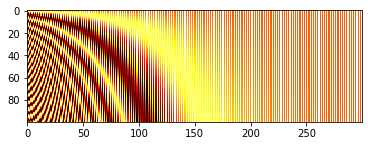

In [ ]:
plt.imshow(pe, cmap='hot', interpolation='nearest')

## Step 4: The encoder block
----

Let us remember the ViT architecture.

<br>

<img src="https://drive.google.com/uc?id=13pDyjjoso32ZsIURUD5ZCI4smlzIwhKm" alt="Drawing" width="800"/>

Source: <a href="https://www.researchgate.net/publication/348947034_Vision_Transformers_for_Remote_Sensing_Image_Classification">Bazi et al. (2021)</a>.

<br>

Now, we will discuss the encoder. We see that it starts with a layer normalisation (LN), after that we have multi-head self-attention (MSA; recall the ```Attention_Mechanism.ipynb``` notebook). Remember that the intuitive idea behind attention is that it allows modelling the relationship between the tokens (words). A remark in the context of ViT is that what makes a "0" (zero) are not the individual pixel values, but how they relate to each other. 

We see a shortcut connection (```+```), another LN and multi-layer perceptron (MLP) network. The MLP is composed of two layers, where the hidden layer typically is four times as big (this is a parameter).



## Step 5: Classification via another MLP
----

Finally, we can extract just the classification token (first token) out of our $N$ sequences, and use each token to get $N$ classifications.

Since we decided that each token is an 8-dimensional vector, and since we have 10 possible digits, we can implement the classification MLP as a simple 8x10 matrix, activated with the softmax function.

## The Full Code
----

Below, we present the full code of this PyTorch ViT from scratch. Some functions have already been defined and we will not repeat here. The full ViT model we call ```ViTFull```.

In [ ]:
# MSA
class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

In [ ]:
# ViT block.
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MyMSA(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d)
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

In [ ]:
# The full ViT
class ViTFull(nn.Module):
    def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
        # Super constructor
        super(ViTFull, self).__init__()
        
        # Attributes
        self.chw = chw # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d
        
        # Input and patches sizes
        assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)
        
        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))
        
        # 3) Positional embedding
        self.register_buffer('positional_embeddings', get_positional_embeddings(n_patches ** 2 + 1, hidden_d), persistent=False)
        
        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList([MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)])
        
        # 5) Classification MLPk
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_d, out_d),
            nn.Softmax(dim=-1)
        )

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)
        
        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)
        
        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)
        
        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)
        
        # Transformer Blocks
        for block in self.blocks:
            out = block(out)
            
        # Getting the classification token only
        out = out[:, 0]
        
        return self.mlp(out) # Map to output dimension, output category distribution

## Main Code
----

In [ ]:
# Loading data
transform = ToTensor()

train_set = MNIST(root='./../datasets', train=True, download=True, transform=transform)
test_set = MNIST(root='./../datasets', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

# Defining model and training options
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
model_full = ViTFull((1, 28, 28), n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10).to(device)
N_EPOCHS = 5
LR = 0.005

print('Full ViT - model\n')
print(model_full)
# Training loop
optimizer = Adam(model_full.parameters(), lr=LR)
criterion = CrossEntropyLoss()
for epoch in trange(N_EPOCHS, desc="Training"):
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
        x, y = batch
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_hat = model_full(x)
        loss = criterion(y_hat, y)

        train_loss += loss.detach().cpu().item() / len(train_loader)

        #optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

# Test loop
with torch.no_grad():
    correct, total = 0, 0
    test_loss = 0.0
    for batch in tqdm(test_loader, desc="Testing"):
        x, y = batch
        x, y = x.to(device), y.to(device)
        y_hat = model_full(x)
        loss = criterion(y_hat, y)
        test_loss += loss.detach().cpu().item() / len(test_loader)

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)
    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {correct / total * 100:.2f}%")

Using device:  cuda (Tesla T4)
Full ViT - model

ViTFull(
  (linear_mapper): Linear(in_features=16, out_features=8, bias=True)
  (blocks): ModuleList(
    (0): MyViTBlock(
      (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
      (mhsa): MyMSA(
        (q_mappings): ModuleList(
          (0): Linear(in_features=4, out_features=4, bias=True)
          (1): Linear(in_features=4, out_features=4, bias=True)
        )
        (k_mappings): ModuleList(
          (0): Linear(in_features=4, out_features=4, bias=True)
          (1): Linear(in_features=4, out_features=4, bias=True)
        )
        (v_mappings): ModuleList(
          (0): Linear(in_features=4, out_features=4, bias=True)
          (1): Linear(in_features=4, out_features=4, bias=True)
        )
        (softmax): Softmax(dim=-1)
      )
      (norm2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=8, out_features=32, bias=True)
        (1): GELU(approxim

Training:  20%|██        | 1/5 [04:35<18:20, 275.02s/it]

Epoch 1/5 loss: 2.08



Training:  40%|████      | 2/5 [09:01<13:30, 270.13s/it]

Epoch 2/5 loss: 1.81



Training:  60%|██████    | 3/5 [13:27<08:56, 268.26s/it]

Epoch 3/5 loss: 1.75



Training:  80%|████████  | 4/5 [17:52<04:26, 266.99s/it]

Epoch 4/5 loss: 1.73



Training: 100%|██████████| 5/5 [22:18<00:00, 267.64s/it]


Epoch 5/5 loss: 1.71


Testing: 100%|██████████| 79/79 [00:25<00:00,  3.06it/s]

Test loss: 1.70
Test accuracy: 76.19%
